## Process CANARI GEV method ##

Same as process_DePreSys_GEV.ipynb, but for the CANARI model. Used to explore uncertainties.

In [1]:
%matplotlib inline

# Local imports
import os
import sys
import time
import argparse
import warnings

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

# Suppress warnings
warnings.filterwarnings('ignore')

# Import the GEV funcs
import gev_functions as gev_funcs

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# set up canari_years
canari_years = np.arange(1950, 2014 + 1)
canari_period = "HIST2"

# Set up the output directory for the dfs
output_dir_dfs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

### Temperature first ###

In [3]:
# ---------------------------------------------------------
# Load the canari model data
# ---------------------------------------------------------

# set up the empty dataframe
model_df_full_canari = pd.DataFrame()

# Check that there are csv files for all of the years
# loop ovber the years
for year in tqdm(canari_years):
    # create the fpath
    fpath = os.path.join(output_dir_dfs, f"canari-le-tas-United_Kingdom-{year}-{canari_period}.csv")
    # check if the file exists
    if not os.path.exists(fpath):
        print(f"Missing file for {year}")
        sys.exit()

    # Load the dataframe
    model_df_this = pd.read_csv(fpath)

    # concatenate the dataframes
    model_df_full_canari = pd.concat([model_df_full_canari, model_df_this], ignore_index=True)

# remove the hh:mm:ss from the time
# time is a str
model_df_full_canari['time'] = model_df_full_canari['time'].str.split(" ").str[0]

# subset the canari model data to D,J,F
# where time is a string
# in the format YYYY-MM-DD
model_df_full_canari_DJF = model_df_full_canari[model_df_full_canari['time'].str.split("-").str[1].isin(["12", "01", "02"])]

# Process the column for data_c
model_df_full_canari_DJF['tas_c'] = model_df_full_canari_DJF['tas'] - 273.15

  0%|          | 0/65 [00:00<?, ?it/s]

100%|██████████| 65/65 [00:21<00:00,  3.07it/s]


In [4]:
# ---------------------------------------------------------
# Load the observed data
# ---------------------------------------------------------

# import the observed data
# load the obs data
df_obs_tas = pd.read_csv(
    f"{output_dir_dfs}/ERA5_tas_United_Kingdom_1960-2018_daily_2024-11-26.csv"
)

# Convert the 'time' column to datetime, assuming it represents days since "1950-01-01 00:00:00"
df_obs_tas["time"] = pd.to_datetime(df_obs_tas["time"], origin="1950-01-01", unit="D")

# subset the obs data to D, J, F
df_obs_tas = df_obs_tas[df_obs_tas["time"].dt.month.isin([12, 1, 2])]

# new column for temp in C
df_obs_tas["data_c"] = df_obs_tas["data"] - 273.15

In [9]:
import importlib
importlib.reload(gev_funcs)

<module 'gev_functions' from '/home/users/benhutch/unseen_multi_year/gev_functions.py'>

In [10]:
# Now we need to add a column for the effctive dec year
df_obs_tas["effective_dec_year"] = df_obs_tas.apply(
    lambda row: gev_funcs.determine_effective_dec_year(row), axis=1
)

# Do the same for CANARI
model_df_full_canari_DJF["effective_dec_year"] = model_df_full_canari_DJF.apply(
    lambda row: gev_funcs.determine_effective_dec_year_canari(row), axis=1
)

In [11]:
df_obs_tas.head()

,time,data,data_c,effective_dec_year
0,1960-01-01,280.004414,6.854414,1959
1,1960-01-02,276.900436,3.750436,1959
2,1960-01-03,278.757843,5.607843,1959
3,1960-01-04,281.210861,8.060861,1959
4,1960-01-05,278.524161,5.374161,1959


In [13]:
model_df_full_canari_DJF.tail()

,member,time,tas,tas_c,effective_dec_year
935995,40,2014-12-26,276.647215,3.497215,2014
935996,40,2014-12-27,274.838709,1.688709,2014
935997,40,2014-12-28,275.233602,2.083602,2014
935998,40,2014-12-29,275.932057,2.782057,2014
935999,40,2014-12-30,275.815959,2.665959,2014


In [14]:
# ---------------------------------------------------------
# Limit both to the same effective_dec_year range
# ---------------------------------------------------------

# Set up the common years
common_years = np.arange(1960, 2013 + 1)

# subset the obs data
df_obs_tas_subset = df_obs_tas[
    df_obs_tas["effective_dec_year"].isin(common_years)
]

# subset the canari data
model_df_full_canari_DJF_subset = model_df_full_canari_DJF[
    model_df_full_canari_DJF["effective_dec_year"].isin(common_years)
]

In [15]:
# ---------------------------------------------------------
# Now quantify the block minima for the winters
# ---------------------------------------------------------

block_minima_obs = gev_funcs.obs_block_min_max(
    df=df_obs_tas_subset,
    time_name="effective_dec_year",
    min_max_var_name="data_c",
    new_df_cols=[],  # no new cols
    process_min=True,
)

In [18]:
# ---------------------------------------------------------
# Now quantify the block maxima for the model winters
# ---------------------------------------------------------

block_minima_canari = gev_funcs.model_block_min_max(
    df=model_df_full_canari_DJF_subset,
    time_name="effective_dec_year",
    min_max_var_name="tas_c",
    new_df_cols=[],  # no new cols
    process_min=True,
)

In [19]:
block_minima_canari.head()

,effective_dec_year,member,tas_c_min
0,1960,1,-1.445395
0,1960,2,-3.529893
0,1960,3,-6.243748
0,1960,4,-5.877452
0,1960,5,-4.750289


In [20]:
block_minima_obs.head()

,effective_dec_year,data_c_min
0,1960,-0.392873
0,1961,-3.468196
0,1962,-6.757083
0,1963,-2.562683
0,1964,-3.339781


In [21]:
# ---------------------------------------------------------
# Now detrend both the model and obs data
# ---------------------------------------------------------

# Detrend the observed data
block_minima_obs_dt = gev_funcs.pivot_detrend_obs(
    df=block_minima_obs,
    x_axis_name="effective_dec_year",
    y_axis_name="data_c_min",
)

# Same for the model data
block_minima_canari_dt = gev_funcs.pivot_detrend_model(
    df=block_minima_canari,
    x_axis_name="effective_dec_year",
    y_axis_name="tas_c_min",
)

In [22]:
block_minima_obs_dt.head()

,effective_dec_year,data_c_min,data_c_min_dt
0,1960,-0.392873,1.809153
0,1961,-3.468196,-1.307717
0,1962,-6.757083,-4.638152
0,1963,-2.562683,-0.485300
0,1964,-3.339781,-1.303945


In [23]:
block_minima_canari_dt.head()

,effective_dec_year,member,tas_c_min,tas_c_min_dt
0,1960,1,-1.445395,0.132080
0,1960,2,-3.529893,-1.952417
0,1960,3,-6.243748,-4.666273
0,1960,4,-5.877452,-4.299977
0,1960,5,-4.750289,-3.172814


In [25]:
importlib.reload(gev_funcs)

<module 'gev_functions' from '/home/users/benhutch/unseen_multi_year/gev_functions.py'>

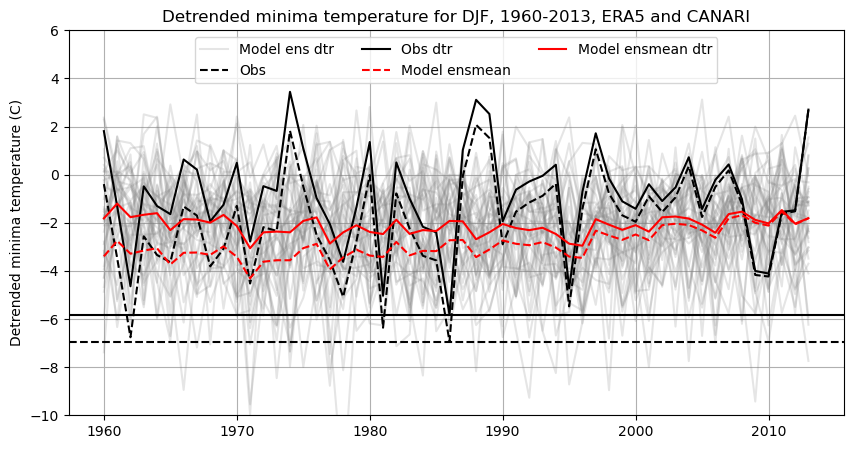

In [27]:
# ---------------------------------------------------------
# Now plot the detrended time series
# ---------------------------------------------------------

gev_funcs.plot_detrend_ts(
    obs_df=block_minima_obs_dt,
    model_df=block_minima_canari_dt,
    obs_var_name="data_c_min",
    model_var_name="tas_c_min",
    obs_time_name="effective_dec_year",
    model_time_name="effective_dec_year",
    ylabel="Detrended minima temperature (C)",
    title="Detrended minima temperature for DJF, 1960-2013, ERA5 and CANARI",
    ylim=(-10, 6),
)

In [28]:
# ---------------------------------------------------------
# Calculate the mean bias in block minima temperatures
# ---------------------------------------------------------

block_minima_canari_dt_bc = gev_funcs.mean_bias_correct(
    model_df=block_minima_canari_dt,
    obs_df=block_minima_obs_dt,
    model_var_name="tas_c_min_dt",
    obs_var_name="data_c_min_dt",
)

Mean bias correction: -1.2655817370680058


In [31]:
%%time
# ---------------------------------------------------------
# Process the GEV params
# --------------------------------------------------------

# Process the GEV params - no bias correction
gev_params_raw = gev_funcs.process_gev_params(
    obs_df=block_minima_obs_dt,
    model_df=block_minima_canari_dt_bc,
    obs_var_name="data_c_min_dt",
    model_var_name="tas_c_min_dt", # No bias correction
    obs_time_name="effective_dec_year",
    model_time_name="effective_dec_year",
    nboot=1000,
)

# Process the GEV params - with bias correction
gev_params_bc = gev_funcs.process_gev_params(
    obs_df=block_minima_obs_dt,
    model_df=block_minima_canari_dt_bc,
    obs_var_name="data_c_min_dt",
    model_var_name="tas_c_min_dt_bc", # With bias correction
    obs_time_name="effective_dec_year",
    model_time_name="effective_dec_year",
    nboot=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:45<00:00, 21.94it/s]

CPU times: user 1min 25s, sys: 498 ms, total: 1min 25s
Wall time: 1min 35s


In [34]:
importlib.reload(gev_funcs)

<module 'gev_functions' from '/home/users/benhutch/unseen_multi_year/gev_functions.py'>

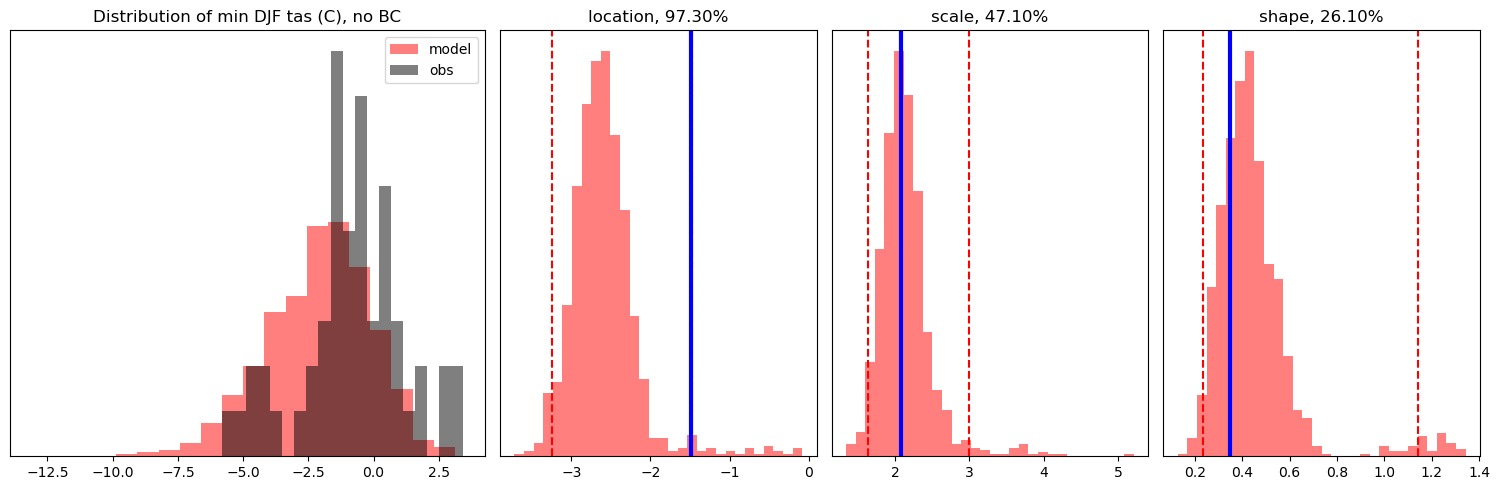

In [38]:
# ---------------------------------------------------------
# Now plot the GEV params
# ---------------------------------------------------------

# First plot the non mean bias corrected one
gev_funcs.plot_gev_params(
    gev_params=gev_params_raw,
    obs_df=block_minima_obs_dt,
    model_df=block_minima_canari_dt_bc,
    obs_var_name="data_c_min_dt",
    model_var_name="tas_c_min_dt",
    title="Distribution of min DJF tas (C), no BC",
    obs_label="obs",
    model_label="model",
    figsize=(15, 5),
)

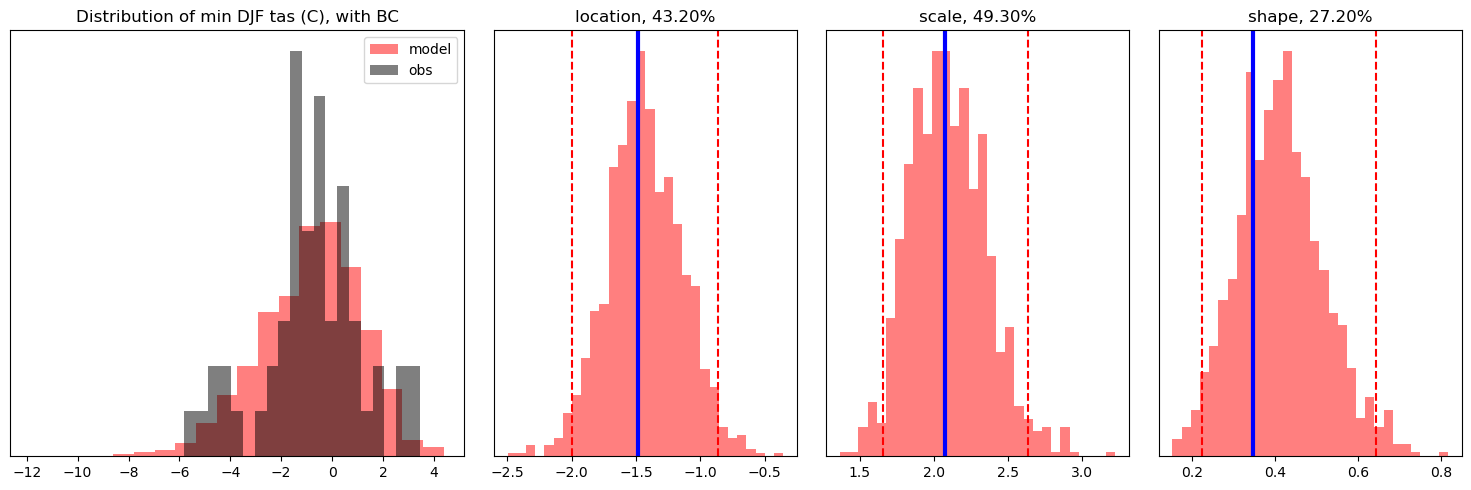

In [37]:
# ---------------------------------------------------------
# Now plot the GEV params for the mean bias corrected one
# ---------------------------------------------------------

gev_funcs.plot_gev_params(
    gev_params=gev_params_bc,
    obs_df=block_minima_obs_dt,
    model_df=block_minima_canari_dt_bc,
    obs_var_name="data_c_min_dt",
    model_var_name="tas_c_min_dt_bc",
    title="Distribution of min DJF tas (C), with BC",
    obs_label="obs",
    model_label="model",
    figsize=(15, 5),
)

In [39]:
# ---------------------------------------------------------
# Specifically import the dot plot function
# ---------------------------------------------------------

sys.path.append("/home/users/benhutch/unseen_functions/")
from functions import dot_plot

In [40]:
# ---------------------------------------------------------
# Preprocess the time data for the dot plot
# ---------------------------------------------------------

# Set effective dec year as a datetime for the obs
block_minima_obs_dt["effective_dec_year"] = pd.to_datetime(
    block_minima_obs_dt["effective_dec_year"], format="%Y"
)

# Set effective dec year as a datetime for the model
block_minima_canari_dt_bc["effective_dec_year"] = pd.to_datetime(
    block_minima_canari_dt_bc["effective_dec_year"], format="%Y"
)

# Set this as the index for the obs
block_minima_obs_dt.set_index("effective_dec_year", inplace=True)

In [41]:
# ---------------------------------------------------------
# Find the coldest year in the obs
# ---------------------------------------------------------

min_value = block_minima_obs_dt["data_c_min_dt"].min()

# Locate the row at which this occurs
min_row = block_minima_obs_dt.loc[block_minima_obs_dt["data_c_min_dt"] == min_value]

# Print the entire row
print(min_row)

                    data_c_min  data_c_min_dt
effective_dec_year                           
1986-01-01           -6.941608      -5.819821


The worst event occurs in the year: 1974-01-01 00:00:00
The no. days for the worst event is: -5.819821167146117
Bad events have low values
The chance of a very bad event is: 1.25%
The chance of a very bad event is: 1 in 80 years
Saving plot to /gws/nopw/j04/canari/users/benhutch/plots/obs-data_c_min_dt_model-tas_c_min_dt_bc_quantile-0.2_solid-min_dot_plot_2025-03-10-10-50-29.pdf


Saved plot to /gws/nopw/j04/canari/users/benhutch/plots/obs-data_c_min_dt_model-tas_c_min_dt_bc_quantile-0.2_solid-min_dot_plot_2025-03-10-10-50-29.pdf


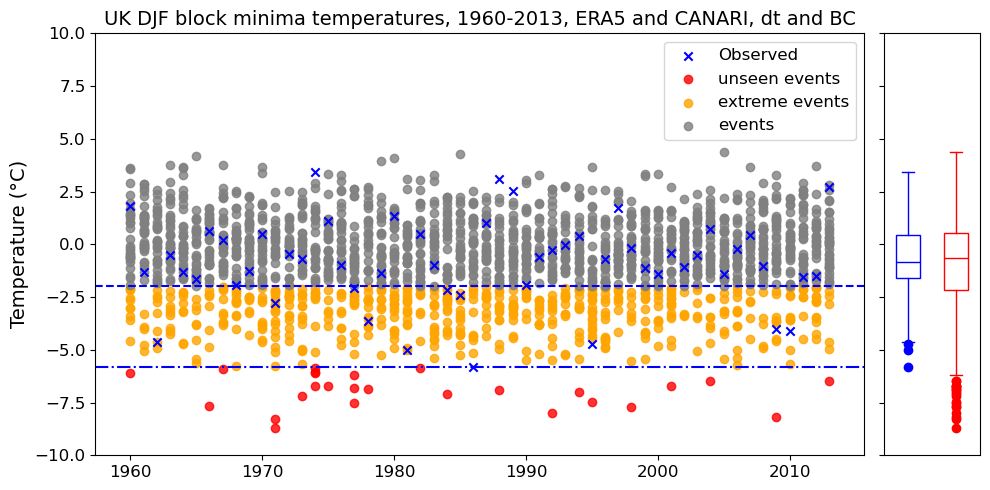

In [44]:
# ---------------------------------------------------------
# Now plot the dot plot for the bias corrected data
# ---------------------------------------------------------

dot_plot(
    obs_df=block_minima_obs_dt,
    model_df=block_minima_canari_dt_bc,
    obs_val_name="data_c_min_dt",
    model_val_name="tas_c_min_dt_bc",
    model_time_name="effective_dec_year",
    ylabel="Temperature (°C)",
    title="UK DJF block minima temperatures, 1960-2013, ERA5 and CANARI, dt and BC",
    ylims=(-10, 10),
    solid_line=np.min,
    dashed_quant=0.2,
)

### Wind speed ###

In [47]:
# ---------------------------------------------------------
# Load the model data
# ---------------------------------------------------------

# Set up the fname
# fname = "CANARI_sfcWind_UK_wind_box_1960-2014_day.csv"

# # Set up the directory in which the model data is stored
model_wind_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

# Set up the empty dataframe
canari_wind = pd.DataFrame()

# Set up the canari_members
canari_members = np.arange(1, 41)

for year in tqdm(canari_years):
    for member in canari_members:
        # create the fpath
        fpath = os.path.join(model_wind_dir, f"canari-le-sfcWind-UK_wind_box-{year}-member-{member}-{canari_period}.csv")
        # check if the file exists
        if not os.path.exists(fpath):
            print(f"Missing file for {year}")
            # sys.exit()

        # # Load the dataframe
        # model_df_this = pd.read_csv(fpath)

        # # concatenate the dataframes
        # canari_wind = pd.concat([canari_wind, model_df_this], ignore_index=True)

 23%|██▎       | 15/65 [00:02<00:09,  5.40it/s]

Missing file for 1963
Missing file for 1963
Missing file for 1963
Missing file for 1963
Missing file for 1963
Missing file for 1963
Missing file for 1963
Missing file for 1963
Missing file for 1963
Missing file for 1963
Missing file for 1963
Missing file for 1963
Missing file for 1963


 29%|██▉       | 19/65 [00:03<00:10,  4.52it/s]

Missing file for 1967
Missing file for 1967
Missing file for 1967
Missing file for 1967
Missing file for 1967
Missing file for 1967
Missing file for 1967
Missing file for 1967
Missing file for 1967
Missing file for 1967
Missing file for 1967
Missing file for 1967
Missing file for 1967
Missing file for 1967
Missing file for 1967
Missing file for 1968
Missing file for 1968
Missing file for 1968
Missing file for 1968
Missing file for 1968
Missing file for 1968
Missing file for 1968
Missing file for 1968
Missing file for 1968
Missing file for 1968
Missing file for 1968
Missing file for 1968
Missing file for 1968
Missing file for 1968


 40%|████      | 26/65 [00:05<00:06,  5.86it/s]

Missing file for 1974
Missing file for 1974
Missing file for 1974
Missing file for 1974
Missing file for 1974
Missing file for 1974
Missing file for 1974
Missing file for 1974
Missing file for 1974
Missing file for 1974
Missing file for 1974
Missing file for 1974
Missing file for 1974
Missing file for 1974
Missing file for 1974
Missing file for 1974
Missing file for 1974


 46%|████▌     | 30/65 [00:05<00:06,  5.68it/s]

Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1979
Missing file for 1980
Missing file for 1980
Missing file for 1980
Missing file for 1980
Missing file for 1980
Missing fi

 63%|██████▎   | 41/65 [00:07<00:03,  6.79it/s]

Missing file for 1990
Missing file for 1990
Missing file for 1990
Missing file for 1990
Missing file for 1990
Missing file for 1990
Missing file for 1990
Missing file for 1990
Missing file for 1990


 71%|███████   | 46/65 [00:09<00:07,  2.53it/s]

Missing file for 1995
Missing file for 1995
Missing file for 1995
Missing file for 1995
Missing file for 1995
Missing file for 1995
Missing file for 1995
Missing file for 1995
Missing file for 1995
Missing file for 1995
Missing file for 1995
Missing file for 1995
Missing file for 1995
Missing file for 1995
Missing file for 1995


 77%|███████▋  | 50/65 [00:09<00:03,  3.91it/s]

Missing file for 1999
Missing file for 1999
Missing file for 1999
Missing file for 1999
Missing file for 1999
Missing file for 1999


 82%|████████▏ | 53/65 [00:10<00:03,  3.72it/s]

Missing file for 2001
Missing file for 2001
Missing file for 2001
Missing file for 2001


 88%|████████▊ | 57/65 [00:11<00:02,  3.75it/s]

Missing file for 2005
Missing file for 2005
Missing file for 2005
Missing file for 2005
Missing file for 2005


 98%|█████████▊| 64/65 [00:13<00:00,  3.46it/s]

Missing file for 2013
Missing file for 2013
Missing file for 2013
Missing file for 2013
Missing file for 2013
Missing file for 2013
Missing file for 2013
Missing file for 2013
Missing file for 2013
Missing file for 2013
Missing file for 2013
Missing file for 2013
Missing file for 2013
Missing file for 2013
Missing file for 2013
Missing file for 2013
Missing file for 2013
Missing file for 2013


100%|██████████| 65/65 [00:13<00:00,  4.64it/s]


In [48]:
test_fpath = "/gws/nopw/j04/canari/shared/large-ensemble/priority//HIST2/26/ATM/yearly/1963/db*a_26_1hr_pt_m01s03i225_2.nc"

# load the cube
cube = iris.load(test_fpath)

In [50]:
model_cube = cube.merge_cube()

cube = model_cube.intersection(longitude=(-180, 180), latitude=(-90, 90))

In [58]:
from iris.util import equalise_attributes

test_fpath = "/gws/nopw/j04/canari/shared/large-ensemble/priority//HIST2/30/ATM/yearly/1963/db305a_30_1hr_pt_m01s03i226_2.nc"

# load the cube
cube = iris.load(test_fpath)

# remove attributes
removed_attrs = equalise_attributes(cube)

model_cube = cube.merge_cube()

cube = model_cube.intersection(longitude=(-180, 180), latitude=(-90, 90))

In [57]:
cube

<iris 'Cube' of northward_wind / (m s-1) (time: 8640; latitude: 325; longitude: 432)>